In [3]:
%matplotlib inline

The [MembraneAccumulation](https://github.com/cespenel/image_processing/blob/73bff17638452184cce6614fe9a571fd6b8845b0/membrane_accumulation/scripts/segmentation_click.py) class was designed to measure the accumulation of a protein (puncta) at the edge of injected cells. 
For this work, I didn't have any marker of the membrane, but the accumulation at the edge of the cells was very clear. However, the protein also accumulates in other part of the cells so it was problematic to segment out only the proteins present at the edge. In order to only measure the accumulation at the edge of the cells, I "draw" a "polyline" following the edge of the cells and use it as a mask to segment out the puncta in this area. 

First we import all the modules we need, I will use the [open_image_bioformat](https://github.com/cespenel/image_processing/blob/73bff17638452184cce6614fe9a571fd6b8845b0/membrane_accumulation/scripts/open_image_bioformat.py): that I discuss in another notebook. I'm also using opencv a great library for image/video processing and analysis.

In [2]:
import open_image_bioformat as oib
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import numpy as np
import cv2
from skimage.filters import threshold_otsu
from skimage import morphology

Let's now see an example of a set of images I have to process and analyse. For that I'll use the open_image_bioformat module that I wrote.

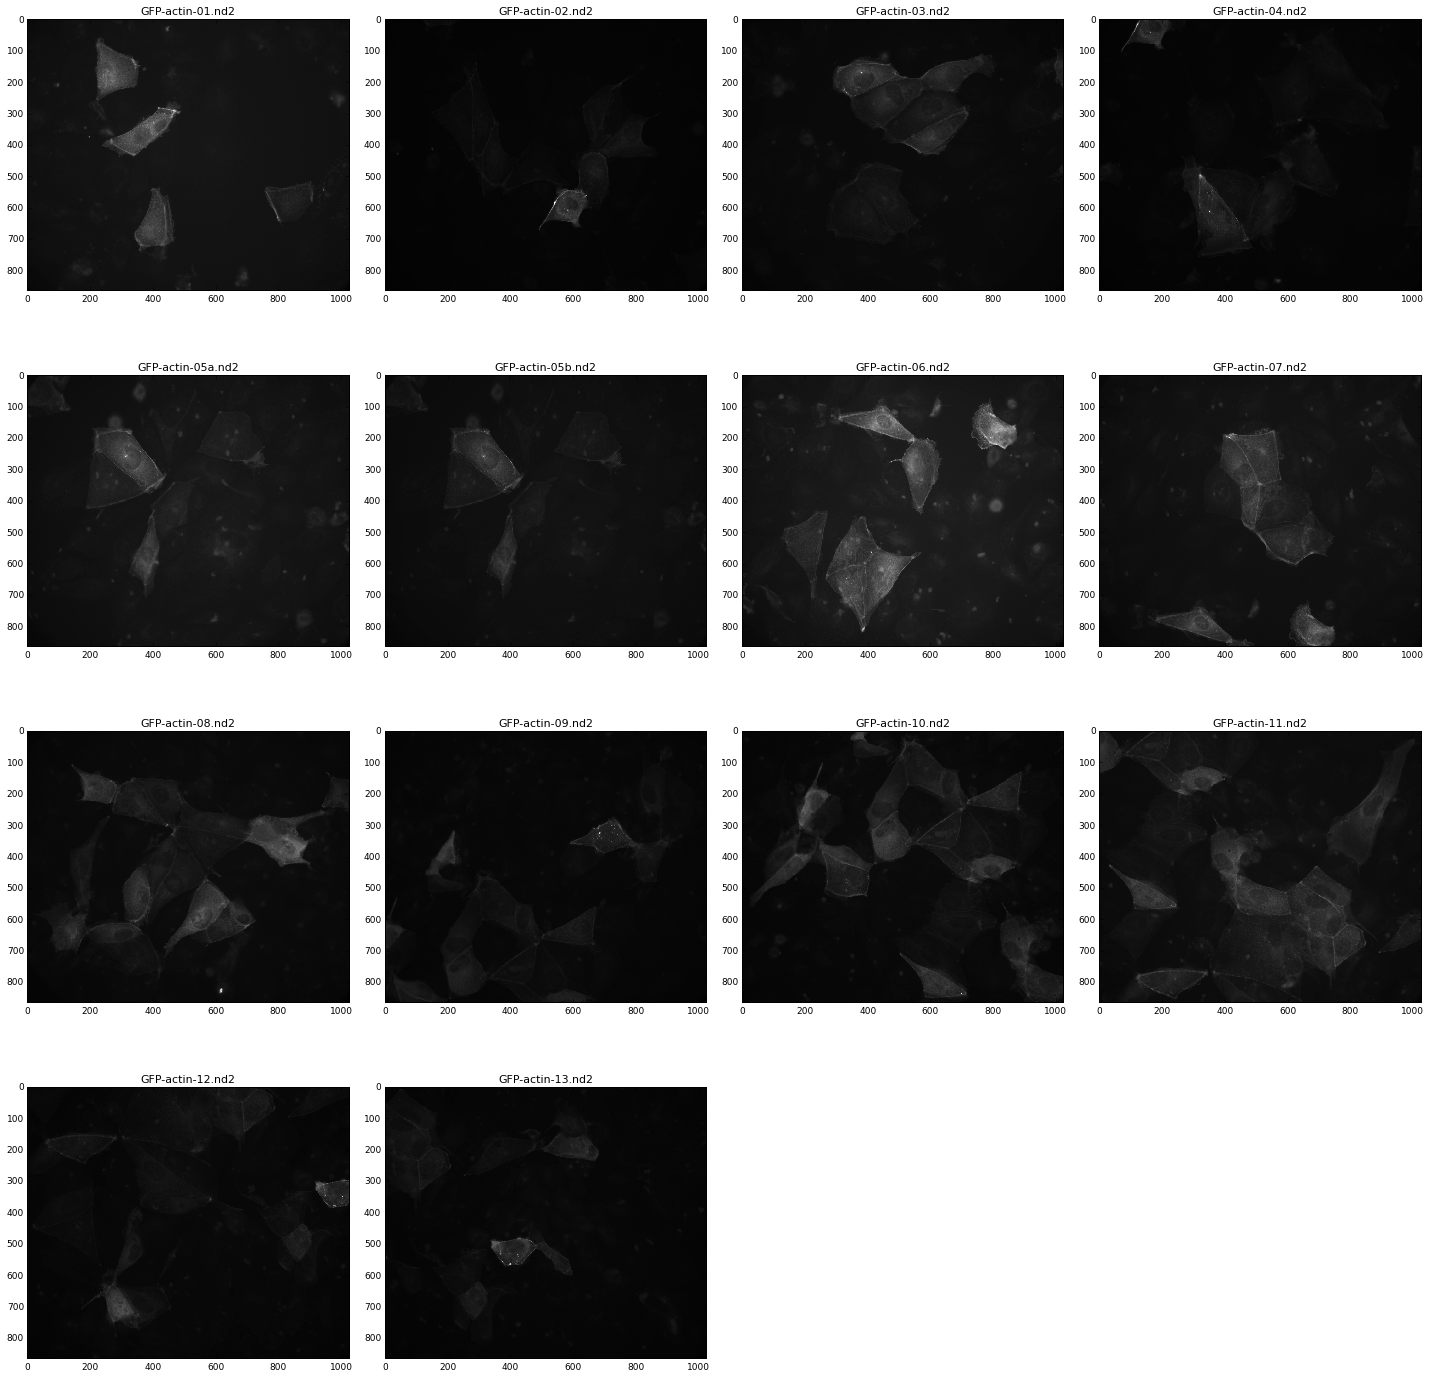

In [4]:
path = "/.../.../.../"
images, im = oib.batch_analysis_bioformat(path, imageformat = 'nd2')
oib.show_series_all(images, path, im, imageformat = '.nd2')

I can now try the class MembraneAccumulation that I wrote to perform the analysis on these images. I will use the image "GFP-actin-10" as an example.

In [9]:
import open_image_bioformat as oib
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import numpy as np
import cv2
from skimage.filters import threshold_otsu
from skimage import morphology
import os
import pandas as pd
import time


class MembraneAccumulation:

    def __init__(self, image):

        self.drawing = False
        self.image = image

        self.coords_cell = []
        self.surface_segmented = []
        self.surface_masked = []

    def click_canvas(self):
        self.fig, (self.ax1) = plt.subplots(1,1, figsize=(15, 8))
        self.ax1.imshow(self.image, cmap=plt.cm.gray, interpolation='nearest')

        # Connection to 3 different events, left click, motion and key press
        self.fig.canvas.mpl_connect('button_press_event', self.onclick)
        self.fig.canvas.mpl_connect('button_release_event', self.click_release)
        self.fig.canvas.mpl_connect('motion_notify_event', self.on_motion)
        self.fig.canvas.mpl_connect('key_press_event', self.press)

        plt.show()

    def onclick(self, event):

        # Will Create a left click event:
        # Get the coordinate of the event and draw a circle.

        if event.button == 1:
            self.drawing = True
            self.coords_cell = [(event.xdata, event.ydata)]

    def click_release(self, event):
        self.drawing = False

    def on_motion(self, event):

        # When click left, will append the coordinate of the mouse while mouving
        # it and draw circles until button is not press anymore.

        if self.drawing == True:
            self.press = self.coords_cell.append((event.xdata, event.ydata))
            circ = Circle((event.xdata, event.ydata), 5, color = 'yellow')
            self.ax1.add_artist(circ)
            self.fig.canvas.draw()

    def press(self, push):

        # Keyboard avent:
        # When press q, the figure will close.

        if push.key == 'q':
            plt.close(self.fig)

        # When press c:
        # ==> Image will be process, segmented and the surface segmented
        # and masked will be measured.

        if push.key == 'c':
            self.CleanImgage()
            self.ImageSegmentation()
            #plt.close(self.fig)
            self.show_result()

        if push.key == 'd':
            self.CleanImgage()
            self.segmentation_crop_area()
            plt.close(self.fig)
            self.show_result()

    def CleanImgage(self, thresh = 30):

        # Image processing

        footprint = np.array([[-1,-1,-1],[-1,8,-1], [-1,-1,-1]])
        self.clean_image = cv2.medianBlur(self.image, 5)
        self.clean_image = cv2.filter2D(self.clean_image,-1,footprint)
        self.clean_image = cv2.medianBlur(self.clean_image, 5)
        self.markers = np.zeros_like(self.image)
        self.markers[self.clean_image < threshold_otsu(self.image)] = 1
        self.markers[self.clean_image >= ((threshold_otsu(self.image)*thresh)/100)] = 2
        self.markers[self.clean_image >= ((threshold_otsu(self.image)*50)/100)] = 3

    def ImageSegmentation(self):

        kernel = np.array(self.coords_cell, np.int32)
        circle = np.zeros(self.image.shape[:2], np.uint8)

        # link with polylines the coordinates of "left click", thickness could be adjusted,
        # Could also fill inside the polyline
        cv2.polylines(circle,[kernel],False,(255,0,0), thickness=5)
        kernel2 = np.array(self.coords_cell, np.int32)
        circle2 = np.zeros(self.image.shape[:2], np.uint8)
        cv2.polylines(circle2,[kernel2],False,(255,0,0), thickness=4)

        # Segmentation of the protein accumulation using watershed
        self.segmentation = morphology.watershed(self.clean_image, self.markers, mask = circle)
        self.segmentation[self.segmentation < 1.5] = 0
        self.segmentation = self.segmentation.astype('uint8')

        # Find contour of the segmented area
        contours,hierarchy = cv2.findContours(self.segmentation, 1, 2)

        # Find countour of the masked area
        contours_circle,hierarchy = cv2.findContours(circle2, 1, 2)
        self.area = [cv2.contourArea(cnt) for cnt in contours if (cv2.contourArea(cnt))!=0.0]

        self.area = sum(self.area)
        self.area_mask = [cv2.contourArea(cnt_cell) for cnt_cell in contours_circle]
        self.area_mask = sum(self.area_mask)

        if self.area > 0:
            self.surface_segmented.append(self.area)
        if self.area_mask > 0:
            self.surface_masked.append(self.area_mask)

    def segmentation_crop_area(self):

        kernel = np.array(self.coords_cell, np.int32)
        circle = np.zeros(self.image.shape[:2], np.uint8)
        cv2.polylines(circle,[kernel],False,(255,0,0), thickness=10)
        crop_img = cv2.bitwise_and(self.image, self.image, mask=circle)
        kernel2 = np.array(self.coords_cell, np.int32)
        circle2 = np.zeros(self.image.shape[:2], np.uint8)
        cv2.polylines(circle2,[kernel2],False,(255,0,0), thickness=2)
        self.segmentation = morphology.watershed(self.clean_image, self.markers, mask = circle)
        self.segmentation[self.segmentation < 1.5] = 0
        self.segmentation = segmentation.astype('uint8')
        contours,hierarchy = cv2.findContours(segmentation, 1, 2)
        contours_circle,hierarchy = cv2.findContours(circle2, 1, 2)
        self.area = [cv2.contourArea(cnt) for cnt in contours if (cv2.contourArea(cnt))!=0.0]
        self.area = sum(self.area)
        self.area_mask = [cv2.contourArea(cnt_cell) for cnt_cell in contours_circle]
        self.area_mask = sum(self.area_mask)

    def show_result(self):

        fig, (ax1) = plt.subplots(figsize=(15, 8))
        ax1.imshow(self.image, cmap=plt.cm.gray, interpolation='nearest')
        ax1.contour(self.segmentation, [1.5], linewidths=1.2, colors='y')
        ax1.axis('off')
        plt.show()

    def result(self):

        ratio = (sum(self.surface_segmented) / sum(self.surface_masked)) * 100

        result={
        'Surface Segmented' : self.surface_segmented,
        'Surface masked' : self.surface_masked,
        'ratio' : ratio
        }

        return self.surface_segmented, self.surface_masked, ratio


<IPython.core.display.Javascript object>


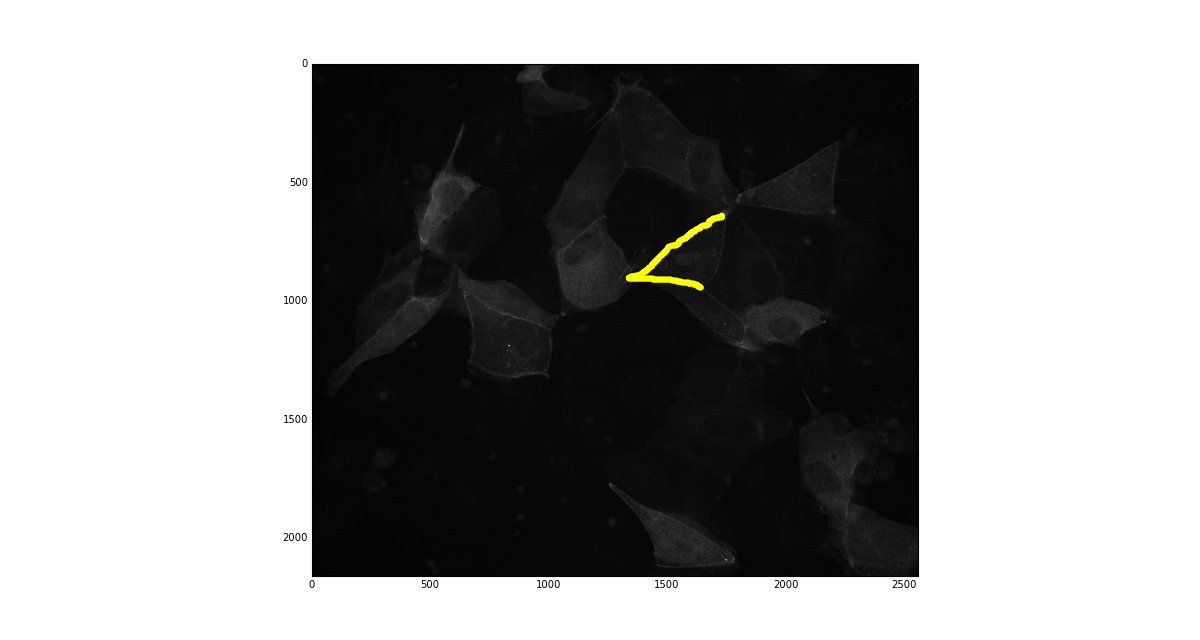

In [10]:
path = "/.../.../GFP-actin-10.nd2"
image = oib.read_bioformat(path)
drawing = MembraneAccumulation(image)

Because the interactive drawing is very slow on the notebook I only did a small area as an example.

<IPython.core.display.Javascript object>


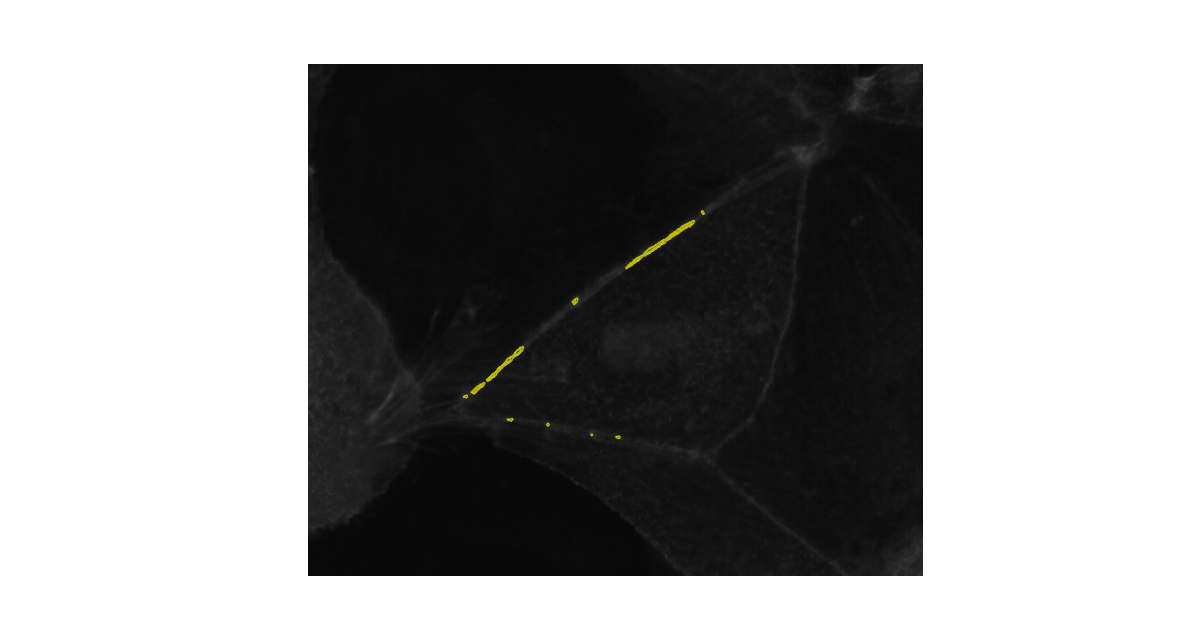

In [11]:
drawing.show_result()

I then extrac the surface covered by the drawn ROIs and the surface segmented. I determine the ratio and I represent the result as a boxplot:

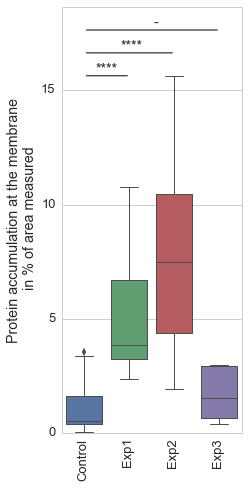

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats
import numpy as np
import seaborn as sns
import os

result = pd.read_csv('/.../.../fig.csv', error_bad_lines=False)
result_head = list(result.columns.values)

dct = {}
for x in result_head:
    dct[x] = [i for i in result[x].tolist() if str(i) != 'nan']

y_max = []
y_min = []

for i in range(1, len(dct)):
    y_max.append(np.max(np.concatenate((dct[result_head[0]], dct[result_head[i]]))))
    y_min.append(np.min(np.concatenate((dct[result_head[0]], dct[result_head[i]]))))

y_max = max(y_max)

p_value = []
for j in range(1, len(dct)):
    z , p = scipy.stats.mannwhitneyu(dct[result_head[0]], dct[result_head[j]])
    p_value.append(p*2)

s = []
for i in range(len(p_value)):
    s.append(stars(p_value[i]))

    
sns.set(style = "whitegrid", font = 'arial',font_scale=1.3, rc={"figure.figsize": (5, 8)})
ax = sns.boxplot(data=result, palette = None, linewidth=1)
ax.set_ylim([(0),(y_max+3)])

def stars(p):
   if p < 0.0001:
       return "****"
   elif (p < 0.001):
       return "***"
   elif (p < 0.01):
       return "**"
   elif (p < 0.05):
       return "*"
   else:
       return '-'

def annotation(ax, y_max, y_min, p_value, from_data = 0, to_data = 1, 
               i = 1.5, j = 1.5, k = 0.081):

    ax.annotate("", xy=(from_data, y_max+i), xytext=(to_data, y_max+i),
                arrowprops=dict(arrowstyle="-", linewidth = 1))
    ax.text(j, y_max+i+0.3, stars(p_value), horizontalalignment='center',
            verticalalignment='center', fontsize = 14)
    
for x in range(len(p_value)):
    annotation(ax, y_max, y_min[x], p_value[x], to_data = (x+1), 
               i = x, j = (0.5+(x/1.85)), k = (0.05*(x+1)))

plt.ylabel('Protein accumulation at the membrane \n in % of area measured')
plt.xticks(rotation=90)
plt.subplots_adjust(left=0.3, right=0.8, top = 0.95, bottom = 0.21)